In [97]:

import math
import numpy
import librosa
from enum import Enum
import struct

#from scipy.spatial.distance import cdist

NUM_MFCC = 13
NUM_MELS = 40
SAMPLE_RATE = 16000
NUM_FFT = 2048
FFT_ORDER  = 512
LOWER_FREQ = 133.333300
HIGHEST_FREQ = 6855.497600
WINDOW_LENGTH = int(0.10 * SAMPLE_RATE)
HOP_LENGTH = int(0.04 * SAMPLE_RATE)
EMPHASIS_FACTOR = 0.97
DTW_MARGIN = 60

class AlignmentAlgorithm(Enum):
    DTW_STRIPE = "DTW_STRIPE"
    DTW_EXACT = "DTW_EXACT"

DTW_ALGORITHM = AlignmentAlgorithm.DTW_EXACT


"""
This module contains the implementation
of dynamic time warping (DTW) algorithms
to align two audio waves, represented by their
Mel-frequency cepstral coefficients (MFCCs).

This module contains the following classes:

* :class:`~aeneas.dtw.DTWAlgorithm`,
  an enumeration of the available algorithms;
* :class:`~aeneas.dtw.DTWAligner`,
  the actual wave aligner;
* :class:`~aeneas.dtw.DTWExact`,
  a DTW aligner implementing the exact (full) DTW algorithm;
* :class:`~aeneas.dtw.DTWStripe`,
  a DTW aligner implementing the Sachoe-Chiba band heuristic.

To align two wave files:

1. build an :class:`~aeneas.dtw.DTWAligner` object,
   passing in the constructor
   the paths of the two wave files
   or their MFCC representations;
2. call :func:`~aeneas.dtw.DTWAligner.compute_path`
   to compute the min cost path between
   the MFCC representations of the two wave files.

.. warning:: This module might be refactored in a future version
"""

class aeneas_dtw():

    def __init__(
        self,
        params, q_audio, r_audio
    ):
        self.params = params
        self.query_audio = q_audio 
        self.ref_audio = r_audio
        self._setup_dtw()

    def compute_accumulated_cost_matrix(self):
        """
        Compute the accumulated cost matrix, and return it.

        Return ``None`` if the accumulated cost matrix cannot be computed
        because one of the two waves is empty after masking (if requested).

        :rtype: :class:`numpy.ndarray` (2D)
        :raises: RuntimeError: if both the C extension and
                               the pure Python code did not succeed.

        .. versionadded:: 1.2.0
        """
        if self.dtw is None:
            assert 0
        return self.dtw.compute_accumulated_cost_matrix()

    def compute_path(self):
        """
        Compute the min cost path between the two waves, and return it.

        Return the computed path as a tuple with two elements,
        each being a :class:`numpy.ndarray` (1D) of ``int`` indices: ::

        ([r_1, r_2, ..., r_k], [s_1, s_2, ..., s_k])

        where ``r_i`` are the indices in the real wave
        and ``s_i`` are the indices in the synthesized wave,
        and ``k`` is the length of the min cost path.

        Return ``None`` if the accumulated cost matrix cannot be computed
        because one of the two waves is empty after masking (if requested).

        :rtype: tuple (see above)
        :raises: RuntimeError: if both the C extension and
                               the pure Python code did not succeed.
        """
        wave_path = self.dtw.compute_path()
        return wave_path    

    def _setup_dtw(self):
        """
        Set the DTW object up.
        """

        # setup
        window_shift = self.params.hop_length/self.params.sr
        delta = int(2 * self.params.dtw_margin / window_shift)
        
        # set the selected algorithm
        if self.params.dtw_algorithm == AlignmentAlgorithm.DTW_EXACT:
            self.dtw = DTWExact(
                self.query_audio.mfcc,
                self.ref_audio.mfcc                
            )
        else:
            self.dtw = DTWStripe(
                self.query_audio.mfcc,
                self.ref_audio.mfcc,
                delta
            )

class DTWStripe():

    def __init__(self, m1, m2, delta):
        self.m1 = m1
        self.m2 = m2
        self.delta = delta

    def compute_path(self):
        try:
            cost_matrix, centers = self._compute_cost_matrix()
            accumulated_cost_matrix = self._compute_accumulated_cost_matrix(cost_matrix, centers)
            best_path = self._compute_best_path(accumulated_cost_matrix, centers)
            return best_path
        except Exception as exc:
            print("An unexpected error occurred while running pure Python code", exc, False, None)
        return (False, None)

    def _compute_cost_matrix(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :]
        mfcc2 = self.m2[1:, :]
        norm2_1 = numpy.sqrt(numpy.sum(mfcc1 ** 2, 0))
        norm2_2 = numpy.sqrt(numpy.sum(mfcc2 ** 2, 0))
        n = mfcc1.shape[1]
        m = mfcc2.shape[1]
        delta = self.delta
        if delta > m:
            delta = m
        cost_matrix = numpy.zeros((n, delta))
        centers = numpy.zeros(n, dtype=int)
        for i in range(n):
            # center j at row i
            center_j = (m * i) // n
            # COMMENTED self.log([u"Center at row %d is %d", i, center_j])
            range_start = max(0, center_j - (delta // 2))
            range_end = range_start + delta
            if range_end > m:
                range_end = m
                range_start = range_end - delta
            centers[i] = range_start
            # COMMENTED self.log([u"Range at row %d is %d %d", i, range_start, range_end])
            for j in range(range_start, range_end):
                tmp = mfcc1[:, i].transpose().dot(mfcc2[:, j])
                tmp /= norm2_1[i] * norm2_2[j]
                cost_matrix[i][j - range_start] = 1 - tmp
        return (cost_matrix, centers)

    def _compute_accumulated_cost_matrix(self, cost_matrix, centers):
        # create accumulated cost matrix
        #
        # a[i][j] = c[i][j] + min(c[i-1][j-1], c[i-1][j], c[i][j-1])
        #
        return self._compute_acm_in_place(cost_matrix, centers)

    def _compute_acm_in_place(self, cost_matrix, centers):
        n, delta = cost_matrix.shape
        current_row = numpy.copy(cost_matrix[0, :])
        # COMMENTED cost_matrix[0][0] = current_row[0]
        for j in range(1, delta):
            cost_matrix[0][j] = current_row[j] + cost_matrix[0][j - 1]
        # fill table
        for i in range(1, n):
            current_row = numpy.copy(cost_matrix[i, :])
            offset = centers[i] - centers[i - 1]
            for j in range(delta):
                cost0 = numpy.inf
                if (j + offset) < delta:
                    cost0 = cost_matrix[i - 1][j + offset]
                cost1 = numpy.inf
                if j > 0:
                    cost1 = cost_matrix[i][j - 1]
                cost2 = numpy.inf
                if ((j + offset - 1) < delta) and ((j + offset - 1) >= 0):
                    cost2 = cost_matrix[i - 1][j + offset - 1]
                cost_matrix[i][j] = current_row[j] + min(cost0, cost1, cost2)
        return cost_matrix

    def _compute_best_path(self, acc_matrix, centers):
        # get dimensions
        n, delta = acc_matrix.shape
        i = n - 1
        j = delta - 1 + centers[i]
        path = [(i, j)]
        # compute best (min cost) path
        while (i > 0) or (j > 0):
            if i == 0:
                path.append((0, j - 1))
                j -= 1
            elif j == 0:
                path.append((i - 1, 0))
                i -= 1
            else:
                offset = centers[i] - centers[i - 1]
                r_j = j - centers[i]
                cost0 = numpy.inf
                if (r_j + offset) < delta:
                    cost0 = acc_matrix[i - 1][r_j + offset]
                cost1 = numpy.inf
                if r_j > 0:
                    cost1 = acc_matrix[i][r_j - 1]
                cost2 = numpy.inf
                if (r_j > 0) and ((r_j + offset - 1) < delta) and ((r_j + offset - 1) >= 0):
                    cost2 = acc_matrix[i - 1][r_j + offset - 1]
                costs = [
                    cost0,
                    cost1,
                    cost2
                ]
                moves = [
                    (i - 1, j),
                    (i, j - 1),
                    (i - 1, j - 1)
                ]
                min_cost = numpy.argmin(costs)
                # COMMENTED self.log([u"Selected min cost move %d", min_cost])
                min_move = moves[min_cost]
                path.append(min_move)
                i, j = min_move
        return path

class DTWExact():

    def __init__(self, m1, m2):
        self.m1 = m1
        self.m2 = m2

    def compute_accumulated_cost_matrix(self):
        cost_matrix = self._compute_cost_matrix()
        accumulated_cost_matrix = self._compute_accumulated_cost_matrix(cost_matrix)
        return accumulated_cost_matrix

    def compute_path(self):
        accumulated_cost_matrix = self.compute_accumulated_cost_matrix()
        best_path = self._compute_best_path(accumulated_cost_matrix)
        return best_path

    def _compute_cost_matrix(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :]
        mfcc2 = self.m2[1:, :]
        norm2_1 = numpy.sqrt(numpy.sum(mfcc1 ** 2, 0))
        norm2_2 = numpy.sqrt(numpy.sum(mfcc2 ** 2, 0))
        # compute dot product
        cost_matrix = mfcc1.transpose().dot(mfcc2)
        # normalize
        norm_matrix = numpy.outer(norm2_1, norm2_2)
        cost_matrix = 1 - (cost_matrix / norm_matrix)
        return cost_matrix

    def _compute_accumulated_cost_matrix(self, cost_matrix):
        # create accumulated cost matrix
        #
        # a[i][j] = c[i][j] + min(c[i-1][j-1], c[i-1][j], c[i][j-1])
        #
        return self._compute_acm_in_place(cost_matrix)

    def _compute_acm_in_place(self, cost_matrix):
        n, m = cost_matrix.shape
        current_row = numpy.copy(cost_matrix[0, :])
        # COMMENTED cost_matrix[0][0] = current_row[0]
        for j in range(1, m):
            cost_matrix[0][j] = current_row[j] + cost_matrix[0][j - 1]
        for i in range(1, n):
            current_row = numpy.copy(cost_matrix[i, :])
            cost_matrix[i][0] = cost_matrix[i - 1][0] + current_row[0]
            for j in range(1, m):
                cost_matrix[i][j] = current_row[j] + min(
                    cost_matrix[i - 1][j],
                    cost_matrix[i][j - 1],
                    cost_matrix[i - 1][j - 1]
                )
        return cost_matrix

    def _compute_best_path(self, acc_matrix):
        # get dimensions
        n, m = acc_matrix.shape
        i = n - 1
        j = m - 1
        path = [(i, j)]
        # compute best (min cost) path
        while (i > 0) or (j > 0):
            if i == 0:
                path.append((0, j - 1))
                j -= 1
            elif j == 0:
                path.append((i - 1, 0))
                i -= 1
            else:
                costs = [
                    acc_matrix[i - 1][j],
                    acc_matrix[i][j - 1],
                    acc_matrix[i - 1][j - 1]
                ]
                moves = [
                    (i - 1, j),
                    (i, j - 1),
                    (i - 1, j - 1)
                ]
                min_cost = numpy.argmin(costs)
                # COMMENTED self.log([u"Selected min cost move %d", min_cost])
                min_move = moves[min_cost]
                path.append(min_move)
                i, j = min_move
        return path

class aeneas_mfcc():
    """
    A class for computing Mel-frequency cepstral coefficients (MFCCs).
    """

    CUTOFF = 0.00001
    """ Cut-off threshold """

    MEL_10 = 2595.0
    """ Base Mel frequency """

    TAG = u"MFCC"

    def __init__(self, params):

        # store parameters in local attributes
        self.filter_bank_size = params.n_mel
        self.mfcc_size = params.n_mfcc
        self.fft_order = params.fft_order
        self.lower_frequency = params.low_freq
        self.upper_frequency = params.high_freq
        self.emphasis_factor = params.emphasis_factor
        self.window_length = params.win_length/params.sr
        self.window_shift = params.hop_length/params.sr

        # initialize DCT matrix
        self._create_dct_matrix()

        # initialized later by compute_from_data()
        self.data = None
        self.sample_rate = None
        self.filters = None
        self.hamming_window = None

    @classmethod
    def _hz2mel(cls, frequency):
        """
        Convert the given frequency in Hz to the Mel scale.

        :param float frequency: the Hz frequency to convert
        :rtype: float
        """
        return cls.MEL_10 * math.log10(1.0 + (frequency / 700.0))

    @classmethod
    def _mel2hz(cls, mel):
        """
        Convert the given Mel value to Hz frequency.

        :param float mel: the Mel value to convert
        :rtype: float
        """
        return 700.0 * (10 ** (mel / cls.MEL_10) - 1)

    def _create_dct_matrix(self):
        """
        Create the not-quite-DCT matrix as used by Sphinx,
        and store it in ```self.s2dct```.
        """
        self.s2dct = numpy.zeros((self.mfcc_size, self.filter_bank_size))
        for i in range(0, self.mfcc_size):
            freq = numpy.pi * float(i) / self.filter_bank_size
            self.s2dct[i] = numpy.cos(freq * numpy.arange(0.5, 0.5 + self.filter_bank_size, 1.0, 'float64'))
        self.s2dct[:, 0] *= 0.5
        self.s2dct = self.s2dct.transpose()

    def _create_mel_filter_bank(self):
        """
        Create the Mel filter bank,
        and store it in ``self.filters``.

        Note that it is a function of the audio sample rate,
        so it cannot be created in the class initializer,
        but only later in :func:`aeneas.mfcc.MFCC.compute_from_data`.
        """
        self.filters = numpy.zeros((1 + (self.fft_order // 2), self.filter_bank_size), 'd')
        dfreq = float(self.sample_rate) / self.fft_order
        nyquist_frequency = self.sample_rate / 2
        if self.upper_frequency > nyquist_frequency:
            self.log_exc(u"Upper frequency %f exceeds Nyquist frequency %f" % (self.upper_frequency, nyquist_frequency), None, True, ValueError)
        melmax = aeneas_mfcc._hz2mel(self.upper_frequency)
        melmin = aeneas_mfcc._hz2mel(self.lower_frequency)
        dmelbw = (melmax - melmin) / (self.filter_bank_size + 1)
        filt_edge = aeneas_mfcc._mel2hz(melmin + dmelbw * numpy.arange(self.filter_bank_size + 2, dtype='d'))

        # TODO can this code be written more numpy-style?
        #      (the performance loss is negligible, it is just ugly to see)
        for whichfilt in range(0, self.filter_bank_size):
            # int() casts to native int instead of working with numpy.float64
            leftfr = int(round(filt_edge[whichfilt] / dfreq))
            centerfr = int(round(filt_edge[whichfilt + 1] / dfreq))
            rightfr = int(round(filt_edge[whichfilt + 2] / dfreq))
            fwidth = (rightfr - leftfr) * dfreq
            height = 2.0 / fwidth
            if centerfr != leftfr:
                leftslope = height / (centerfr - leftfr)
            else:
                leftslope = 0
            freq = leftfr + 1
            while freq < centerfr:
                self.filters[freq, whichfilt] = (freq - leftfr) * leftslope
                freq = freq + 1
            # the next if should always be true!
            if freq == centerfr:
                self.filters[freq, whichfilt] = height
                freq = freq + 1
            if centerfr != rightfr:
                rightslope = height / (centerfr - rightfr)
            while freq < rightfr:
                self.filters[freq, whichfilt] = (freq - rightfr) * rightslope
                freq = freq + 1

    def _pre_emphasis(self):
        """
        Pre-emphasize the entire signal at once by self.emphasis_factor,
        overwriting ``self.data``.
        """
        self.data = numpy.append(self.data[0], self.data[1:] - self.emphasis_factor * self.data[:-1])

    def compute_from_data(self, data, sample_rate):
        """
        Compute MFCCs for the given audio data.

        The audio data must be a 1D :class:`numpy.ndarray`,
        that is, it must represent a monoaural (single channel)
        array of ``float64`` values in ``[-1.0, 1.0]``.

        :param data: the audio data
        :type  data: :class:`numpy.ndarray` (1D)
        :param int sample_rate: the sample rate of the audio data, in samples/s (Hz)
        :raises: ValueError: if the data is not a 1D :class:`numpy.ndarray` (i.e., not mono),
                             or if the data is empty
        :raises: ValueError: if the upper frequency defined in the ``rconf`` is
                             larger than the Nyquist frequenct (i.e., half of ``sample_rate``)
        """
        def _process_frame(self, frame):
            """
            Process each frame, returning the log(power()) of it.
            """
            # apply Hamming window
            frame *= self.hamming_window
            # compute RFFT
            fft = numpy.fft.rfft(frame, self.fft_order)
            # equivalent to power = fft.real * fft.real + fft.imag * fft.imag
            power = numpy.square(numpy.absolute(fft))
            #
            # return the log(power()) of the transformed vector
            # v1
            # COMMENTED logspec = numpy.log(numpy.dot(power, self.filters).clip(self.CUTOFF, numpy.inf))
            # COMMENTED return numpy.dot(logspec, self.s2dct) / self.filter_bank_size
            # v2
            return numpy.log(numpy.dot(power, self.filters).clip(self.CUTOFF, numpy.inf))

        if len(data.shape) != 1:
            self.log_exc(u"The audio data must be a 1D numpy array (mono).", None, True, ValueError)
        if len(data) < 1:
            self.log_exc(u"The audio data must not be empty.", None, True, ValueError)

        self.data = data
        self.sample_rate = sample_rate

        # number of samples in the audio
        data_length = len(self.data)

        # frame length in number of samples
        frame_length = int(self.window_length * self.sample_rate)

        # frame length must be at least equal to the FFT order
        frame_length_padded = max(frame_length, self.fft_order)

        # frame shift in number of samples
        frame_shift = int(self.window_shift * self.sample_rate)

        # number of MFCC vectors (one for each frame)
        # this number includes the last shift,
        # where the data will be padded with zeros
        # if the remaining samples are less than frame_length_padded
        number_of_frames = int((1.0 * data_length) / frame_shift)

        # create Hamming window
        self.hamming_window = numpy.hamming(frame_length_padded)

        # build Mel filter bank
        self._create_mel_filter_bank()

        # pre-emphasize the entire audio data
        self._pre_emphasis()

        # allocate the MFCCs matrix
        # v1
        # COMMENTED mfcc = numpy.zeros((number_of_frames, self.mfcc_size), 'float64')
        # v2
        mfcc = numpy.zeros((number_of_frames, self.filter_bank_size), 'float64')

        # compute MFCCs one frame at a time
        for frame_index in range(number_of_frames):
            # COMMENTED print("Computing frame %d / %d" % (frame_index, number_of_frames))

            # get the start and end indices for this frame,
            # do not overrun the data length
            frame_start = frame_index * frame_shift
            frame_end = min(frame_start + frame_length_padded, data_length)

            # frame is zero-padded if the remaining samples
            # are less than its length
            frame = numpy.zeros(frame_length_padded)
            frame[0:(frame_end - frame_start)] = self.data[frame_start:frame_end]

            # process the frame
            mfcc[frame_index] = _process_frame(self, frame)

        # v1
        # COMMENTED return mfcc
        # v2
        # return the dot product with the DCT matrix
        return numpy.dot(mfcc, self.s2dct) / self.filter_bank_size


def mfccs_to_secs(params, val):
    return val * params.hop_length / params.sr

def secs_to_mfccs(params, val):
    return int(val * params.sr / params.hop_length)
    
class AlignmentPair:

    def __init__(self, params, q_audio, r_audio):

        self.params = params
        self.query_audio = q_audio
        self.ref_audio = r_audio
        
        assert len(q_audio.labels) == len(r_audio.labels)
                    
    def get_segment_deviation(self, alignment_obj, query_audio, 
                                 aligned_indices, 
                                 aligned_indices_mfcc):
    
        params = self.params
        query_labels = query_audio.labels
        
        assert len(query_labels) == len(aligned_indices)
        
        assert alignment_obj.num_segments == len(query_labels)
        
        total_energy = numpy.sum(query_audio.audio**2)
        
        for i in range(0, len(query_labels)):
            exp_end = query_labels[i]["end"]
            act_end = aligned_indices[i]["end"]
                        
            end_diff = abs(exp_end - act_end)
    
            start_sample = int(min(exp_end, act_end) * params.sr)
            end_sample = int(max(exp_end, act_end) * params.sr)
        
            y = query_audio.audio[start_sample:end_sample]   
            energy = numpy.sum(y**2) / total_energy
            
            alignment_obj.seg_end_deviation[i] += end_diff
            alignment_obj.seg_energy_deviation[i] += energy
            
    def _calc_alignment_deviation(self, query_audio, 
                                 aligned_indices, 
                                 aligned_indices_mfcc):
    
        params = self.params
        query_labels = query_audio.labels
        end_diff_arr = []
        energy_diff_arr = []
        total_end_diff, total_energy_diff = 0,0
        
        assert len(query_labels) == len(aligned_indices)
        
        total_energy = numpy.sum(query_audio.audio**2)
        
        for i in range(0, len(query_labels)):
            exp_end = query_labels[i]["end"]
            act_end = aligned_indices[i]["end"]
                        
            end_diff = abs(exp_end - act_end)
            total_end_diff += end_diff
    
            start_sample = int(min(exp_end, act_end) * params.sr)
            end_sample = int(max(exp_end, act_end) * params.sr)
        
            y = query_audio.audio[start_sample:end_sample]   
            energy = numpy.sum(y**2) / total_energy
            total_energy_diff += energy
            
            if (len(end_diff_arr)):
                inserted = 0
                for j in range(0, len(end_diff_arr)):
                    if (end_diff < end_diff_arr[j]):
                        end_diff_arr.insert(j, end_diff)
                        inserted = 1
                        break
                if (inserted == 0):
                    end_diff_arr.append(end_diff)
            else:
                end_diff_arr.append(end_diff)
    
            if (len(energy_diff_arr)):
                inserted = 0
                for j in range(0, len(energy_diff_arr)):
                    if (energy < energy_diff_arr[j]):
                        energy_diff_arr.insert(j, energy)
                        inserted = 1
                        break
                if (inserted == 0):
                    energy_diff_arr.append(energy)
            else:
                energy_diff_arr.append(energy)

        return total_end_diff/len(query_labels), \
            total_energy_diff/len(query_labels), \
            end_diff_arr[int(len(query_labels)/2)], \
            energy_diff_arr[int(len(query_labels)/2)]
    
    def _find_alignment_range(self, start, end, wp, search_start):

        alignment_st, alignment_end = -1, -1
        for i in range(search_start, len(wp)):

            if (wp[i][1] == start and alignment_st == -1):
                assert alignment_end == -1
                alignment_st = wp[i][0]
                
            if (wp[i][1] > end):
                if (end != wp[i-1][1]):
                    print("end %d i %d val %d curr %d" 
                          %(end, i, wp[i-1][1], wp[i][1]))
                    assert 0
                alignment_end = wp[i-1][0]
                break

        if (alignment_st == -1):
            print("ERROR : i %d start %d len %d" 
                  %(i, search_start, len(wp)))
        if (alignment_end == -1):
            alignment_end = wp[i][0]
            
        return alignment_st, alignment_end, i-1

    def _get_alignment_indices(self, wp, ref_labels):
        aligned_indices = []
        aligned_indices_mfcc = []
        search_start = 0
        for i in range(0, len(ref_labels)):
            ref_st = secs_to_mfccs(self.params, ref_labels[i]["start"])
            ref_end = secs_to_mfccs(self.params, ref_labels[i]["end"])
            alignment_st, alignment_end, search_start = \
            self._find_alignment_range(ref_st, ref_end, wp, search_start)
            aligned_indices_mfcc.append(
                                {"start": alignment_st, 
                               "end": alignment_end})
            aligned_indices.append(
                            {"start": mfccs_to_secs(self.params, alignment_st), 
                             "end": mfccs_to_secs(self.params, alignment_end)})
        return aligned_indices, aligned_indices_mfcc

    def get_alignment_deviation_normal(self):
        wp = self.wp[::-1]
        aligned_indices, aligned_indices_mfcc = \
            self._get_alignment_indices(wp, self.ref_audio.labels)
        return self._calc_alignment_deviation(self.query_audio, 
                                     aligned_indices, 
                                     aligned_indices_mfcc)

    def get_alignment_deviation_swap(self):
        wp = [(point[1], point[0]) for point in self.wp]
        wp = wp[::-1]
        aligned_indices, aligned_indices_mfcc = \
            self._get_alignment_indices(wp, self.query_audio.labels)
        return self._calc_alignment_deviation(self.ref_audio, 
                                     aligned_indices, 
                                     aligned_indices_mfcc)
    
    def dump_warping_path(self, f_name):
        
        with open(f_name, "wb") as f:
            f.write(struct.pack("<i", len(self.wp)))
            for x, y in self.wp:
              f.write(struct.pack("<ii", x, y))
              
    def set_warping_path(self, f_name):
        self.wp= []
        with open(f_name, "rb") as f:
            # Read the number of elements
            num_elements = struct.unpack("<i", f.read(4))[0]
            
            for _ in range(num_elements):
              x, y = struct.unpack("<ii", f.read(8))
              self.wp.append((x, y))    

class AlignmentPairLibrosa(AlignmentPair):

    def get_warping_path(self):

        params = self.params
        q_audio = self.query_audio
        r_audio = self.ref_audio
        
        g_c_val = True
        if (params.dtw_algorithm == AlignmentAlgorithm.DTW_EXACT):
            g_c_val = False
        
        assert len(q_audio.labels) == len(r_audio.labels)
                
        #distance = cdist(q_audio.mfcc.T, r_audio.mfcc.T)
        #D, self.wp = librosa.sequence.dtw(C = distance, subseq=False)
        _, self.wp = librosa.sequence.dtw(q_audio.mfcc, 
                                          r_audio.mfcc,
                                          global_constraints=g_c_val,
                                          backtrack=True)

class AlignmentPairAeneas(AlignmentPair):

    def get_warping_path(self):

        params = self.params
        q_audio = self.query_audio
        r_audio = self.ref_audio
        
        assert len(q_audio.labels) == len(r_audio.labels)
                
        a_dtw = aeneas_dtw(params, q_audio, r_audio)
        self.wp = a_dtw.compute_path()

class AudioText:
    
    def __init__(self, params, filename, labelname):
        self.params = params
        self.filename = filename
        self.labelname = labelname
        self.labels  = self._construct_labels(labelname)
        self.audio, sample_rate = librosa.load(self.filename, sr=params.sr)

    def _construct_labels(self, labelname):
        
        begin, end = -1,-1
        labels = []
        word="NULL"
        with open(labelname, "r", encoding="utf-8") as fp:
            lines = fp.readlines()
            line_idx = 0
            for line in lines:
                word = 'begin'
                if line.find(word) != -1:
                    parts = line.split(": \"")
                    assert(end == -1)
                    assert(begin == -1)            
                    begin = float(parts[1][0:-3])
                word = 'end'
                if line.find(word) != -1:
                    parts = line.split(": \"")
                    assert(end == -1)
                    assert(begin != -1)            
                    end = float(parts[1][0:-3])
                word = 'lines'
                if line.find(word) != -1:
                    word = lines[line_idx + 1]
                    labels.append({"start": begin, 
                                   "end": end, "text": word[5:-2]})
                    begin, end = -1,-1
                line_idx += 1
        return labels    
    
class AudioTextLibrosa(AudioText):
    def calc_mfcc(self, params):
        self.mfcc = librosa.feature.mfcc(
            y=self.audio,
            sr=params.sr,
            n_mfcc=params.n_mfcc,
            win_length=params.win_length,
            hop_length=params.hop_length,
            n_mels = params.n_mel,
            n_fft = params.n_fft,
            fmin = params.low_freq,
            fmax = params.high_freq,
            center=False,
        )
        self.__middle_begin = 0
        self.__middle_end = self.mfcc.shape[1]

class AudioTextAeneas(AudioText):
    def calc_mfcc(self, params):
        self.mfcc = aeneas_mfcc(params
            ).compute_from_data(
            self.audio, params.sr
        ).transpose()
                
class Alignment:

    def __init__(self,
               sr=SAMPLE_RATE, 
               n_fft=NUM_FFT,
               hop_length=HOP_LENGTH,
               window_length=WINDOW_LENGTH, 
               n_mfcc=NUM_MFCC, 
               n_mel=NUM_MELS, 
               low_freq=LOWER_FREQ, 
               high_freq=HIGHEST_FREQ,
               algorithm=DTW_ALGORITHM
               ):
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = window_length
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.n_mel = n_mel
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.dtw_algorithm = algorithm
        
class AlignmentLibrosa(Alignment):

    def audio_text(self, filename, labelname):
        return AudioTextLibrosa(self, filename, labelname)
    
    def alignment_pair(self, q_audio, r_audio):
        return AlignmentPairLibrosa(self, q_audio, r_audio)
    
class AlignmentAeneas(Alignment):
    def __init__(self, 
                sr=SAMPLE_RATE, 
                n_fft=NUM_FFT,
                hop_length=HOP_LENGTH,
                window_length=WINDOW_LENGTH, 
                n_mfcc=NUM_MFCC, 
                n_mel=NUM_MELS, 
                low_freq=LOWER_FREQ, 
                high_freq=HIGHEST_FREQ,
                algorithm=DTW_ALGORITHM,
                fft_order=FFT_ORDER,
                emphasis_factor = EMPHASIS_FACTOR,
                dtw_margin=DTW_MARGIN):
        super().__init__(sr=SAMPLE_RATE, 
                       n_fft=n_fft,
                       hop_length=hop_length,
                       window_length=window_length, 
                       n_mfcc=n_mfcc, 
                       n_mel=n_mel, 
                       low_freq=low_freq, 
                       high_freq=high_freq,
                       algorithm=algorithm
                       )
        self.fft_order = fft_order
        self.emphasis_factor = emphasis_factor
        self.dtw_margin = dtw_margin
        self.ap_arr = []
        
    def audio_text(self, filename, labelname):
        return AudioTextAeneas(self, filename, labelname)
    
    def alignment_pair(self, q_audio, r_audio):
        ap = AlignmentPairAeneas(self, q_audio, r_audio)
        self.ap_arr.append(ap)
        return ap
    
    def get_segment_deviations(self):
        for i in range(0, len(self.ap_arr)):
            ap = self.ap_arr[i]
            if (i == 0):
                self.num_segments = len(ap.ref_audio.labels)
                self.seg_end_deviation = numpy.zeros(self.num_segments)
                self.seg_energy_deviation = numpy.zeros(self.num_segments)
            else:
                assert self.num_segments == len(ap.ref_audio.labels)
                
            wp = ap.wp[::-1]
            aligned_indices, aligned_indices_mfcc = \
                ap._get_alignment_indices(wp, ap.ref_audio.labels)
            ap.get_segment_deviation(self, ap.query_audio ,aligned_indices, aligned_indices_mfcc)
            return self.seg_end_deviation, self.seg_energy_deviation


1. Create an alignment object for librosa based alignment.
2. Parse the dataset directory and create an audio text object for each of the 14 datasets.
   Load the audio, calulate the mfcc's and read the json file prepared using finetune aeneas
   and get the start and end labels.

In [93]:
g_a = AlignmentAeneas(algorithm=AlignmentAlgorithm.DTW_STRIPE)

In [73]:
import os
import glob
at_a_arr = []
dir = r"C:\Users\Lenovo\Desktop\sishya\audio alignment vs\audio_alignment - nama\dataset - after final tune"
for sb in os.listdir(dir):
    f_a = r"%s\audio.mp3"%(os.path.join(dir, sb))       
    f_l = r"%s\label.json"%(os.path.join(dir, sb))

    at_a = g_a.audio_text(f_a, f_l)
    at_a.calc_mfcc(g_a)
    at_a_arr.append(at_a)


In [98]:
end_mean_arr = numpy.zeros((len(at_a_arr), len(at_a_arr)))
end_median_arr = numpy.zeros((len(at_a_arr), len(at_a_arr)))
energy_mean_arr = numpy.zeros((len(at_a_arr), len(at_a_arr)))
energy_median_arr = numpy.zeros((len(at_a_arr), len(at_a_arr)))

for r_idx in range(0, len(at_a_arr)):
    #print("Checking form bin file for r:", r_idx)
    for q_idx in range(r_idx+1, len(at_a_arr)):
        #print("Checking for q:", q_idx)
        ap_a_b = g_a.alignment_pair(at_a_arr[q_idx], at_a_arr[r_idx])
        ap_a_b.set_warping_path(r"C:\Users\Lenovo\Desktop\sishya\wps_after_final_tune\aeneas\%d_%d.bin" %(q_idx, r_idx))
        
        end_mean_arr[q_idx][r_idx], \
        energy_mean_arr[q_idx][r_idx], \
        end_median_arr[q_idx][r_idx], \
        energy_median_arr[q_idx][r_idx] = ap_a_b.get_alignment_deviation_normal()
        
        end_mean_arr[r_idx][q_idx], \
        energy_mean_arr[r_idx][q_idx], \
        end_median_arr[r_idx][q_idx], \
        energy_median_arr[r_idx][q_idx] = ap_a_b.get_alignment_deviation_swap()
print("DONE")

DONE


In [99]:
len(g_a.ap_arr)

106

In [101]:
num_pairs, total = 0, 0
for i in range(0, end_mean_arr.shape[0]):
    for j in range(0, end_mean_arr.shape[1]):
        if (i == j):
            continue
        total += end_mean_arr[i][j]
        if (end_mean_arr[i][j] > 0.5):
            print("i %d j %d val %f" %(i, j, end_mean_arr[i][j]))
        num_pairs += 1
total/num_pairs

i 2 j 4 val 0.758662
i 3 j 4 val 20.760363
i 4 j 1 val 0.570000
i 4 j 2 val 0.989773
i 4 j 3 val 32.533401
i 4 j 9 val 1.095442
i 4 j 11 val 0.624195
i 4 j 13 val 0.732449
i 6 j 0 val 0.544739
i 6 j 1 val 0.555533
i 6 j 2 val 0.517846
i 6 j 3 val 0.546553
i 6 j 5 val 0.571723
i 6 j 8 val 1.129819
i 6 j 10 val 0.637982
i 8 j 6 val 0.625170
i 9 j 4 val 0.710227


0.4846841593780371

In [102]:
a,b = g_a.get_segment_deviations()

In [103]:
max_val = 0
idx = -1
total_val = 0
for i in range(0, len(a)):
    total_val += a[i]
    if (a[i] > max_val):
        max_val = a[i]
        idx = i
max_val, idx, total_val/len(a)

(1.5600000000000023, 39, 0.19848072562358135)

In [104]:
max_val = 0
idx = -1
total_val = 0
for i in range(0, len(b)):
    total_val += b[i]
    if (b[i] > max_val):
        max_val = b[i]
        idx = i
max_val, idx, total_val/len(b)

(0.0015899705467745662, 427, 3.0818918193636055e-05)

In [105]:
max_val = 0
idx = -1
total_val = 0
a_copy = []
idx_arr = []
a_copy.append(a[0])
idx_arr.append(0)
for i in range(1, len(a)):
    inserted = 0
    for j in range(0, len(a_copy)):
        if (a[i] < a_copy[j]):
            a_copy.insert(j, a[i])
            idx_arr.insert(j, i)
            inserted = 1
            break
    if (inserted == 0):
        a_copy.append(a[i])
        idx_arr.append(i)
a_copy[len(a_copy)-1], idx_arr[len(a_copy)-1]

(1.5600000000000023, 39)

In [107]:
idx_arr

[0,
 6,
 9,
 10,
 11,
 21,
 27,
 28,
 30,
 33,
 41,
 47,
 49,
 50,
 51,
 53,
 54,
 55,
 68,
 73,
 77,
 90,
 93,
 98,
 115,
 134,
 152,
 170,
 182,
 204,
 206,
 207,
 214,
 220,
 226,
 231,
 246,
 248,
 254,
 256,
 264,
 266,
 274,
 276,
 278,
 282,
 292,
 294,
 314,
 320,
 322,
 334,
 346,
 354,
 360,
 368,
 370,
 385,
 410,
 415,
 431,
 432,
 437,
 438,
 202,
 230,
 236,
 22,
 94,
 142,
 194,
 210,
 216,
 260,
 268,
 330,
 384,
 2,
 70,
 144,
 162,
 178,
 225,
 308,
 326,
 429,
 198,
 296,
 328,
 336,
 24,
 52,
 60,
 394,
 92,
 104,
 112,
 118,
 127,
 128,
 156,
 168,
 176,
 232,
 238,
 240,
 243,
 247,
 255,
 259,
 265,
 270,
 280,
 286,
 290,
 295,
 297,
 306,
 309,
 321,
 332,
 356,
 361,
 369,
 376,
 378,
 388,
 398,
 402,
 405,
 414,
 421,
 433,
 436,
 42,
 44,
 59,
 66,
 67,
 75,
 76,
 83,
 84,
 86,
 5,
 15,
 17,
 26,
 48,
 85,
 106,
 113,
 114,
 122,
 147,
 150,
 158,
 160,
 200,
 218,
 239,
 242,
 258,
 262,
 302,
 310,
 335,
 338,
 359,
 382,
 396,
 344,
 426,
 18,
 244,
 284

In [108]:
max_val = 0
idx = -1
total_val = 0
b_copy = []
idx_arr = []
b_copy.append(b[0])
idx_arr.append(0)
for i in range(1, len(b)):
    inserted = 0
    for j in range(0, len(b_copy)):
        if (b[i] < b_copy[j]):
            b_copy.insert(j, b[i])
            idx_arr.insert(j, i)
            inserted = 1
            break
    if (inserted == 0):
        b_copy.append(b[i])
        idx_arr.append(i)
b_copy[len(b_copy)-1], idx_arr[len(b_copy)-1]

(0.0015899705467745662, 427)

In [109]:
b_copy

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.280504006803909e-10,
 1.6599138730200025e-09,
 2.652574826456089e-09,
 3.0185094423984538e-09,
 3.0700586517440343e-09,
 3.2308822284221606e-09,
 3.7213820913706286e-09,
 3.90025878260758e-09,
 4.194238290011754e-09,
 4.6633155115216596e-09,
 4.666260267072175e-09,
 5.343138376190382e-09,
 5.380009326927393e-09,
 5.524036783555175e-09,
 5.625387267116366e-09,
 5.9310978350879395e-09,
 6.333721547235882e-09,
 7.219574715833232e-09,
 7.226348408551075e-09,
 7.232559884329248e-09,
 7.237058508025029e-09,
 7.279695513062734e-09,
 7.332470186582896e-09,
 8.289818609341637e-09,
 8.391882744263057e-09,
 8.4485511

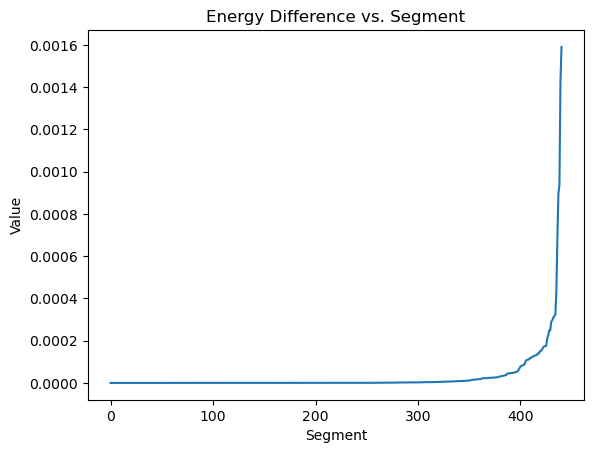

In [113]:
import matplotlib.pyplot as plt

# Sample data (replace with your own data)
data = b_copy

# Create the plot
plt.plot(data)

# Set axis labels
plt.xlabel("Segment")
plt.ylabel("Value")

# Add a title (optional)
plt.title("Energy Difference vs. Segment")

# Display the plot
plt.show()


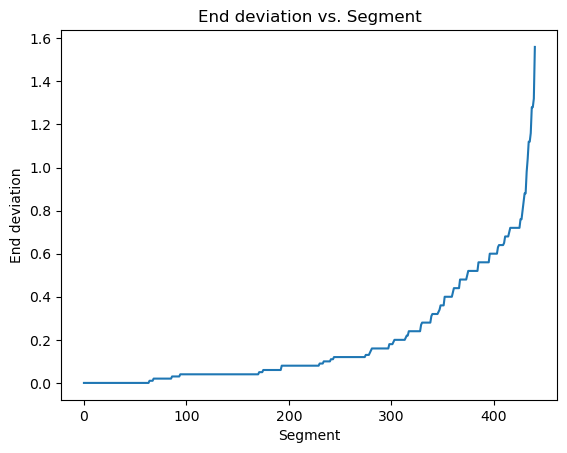

In [114]:

# Sample data (replace with your own data)
data = a_copy

# Create the plot
plt.plot(data)

# Set axis labels
plt.xlabel("Segment")
plt.ylabel("End deviation")

# Add a title (optional)
plt.title("End deviation vs. Segment")

# Display the plot
plt.show()
